[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/casangi/astrohack/blob/main/docs/tutorial_vla.ipynb)

![astrohack](_media/astrohack_logo.png)

In [2]:
import os

from importlib.metadata import version

try:
    import astrohack
    
    print('AstroHACK version', version('astrohack'), 'already installed.')
except ImportError as e:
    print(e)
    print('Installing AstroHACK')
    
    os.system("pip install astrohack")
    
    import astrohack 
    print('astrohack version', version('astrohack'), ' installed.')

AstroHACK version 0.2.3 already installed.


# `locit` VLA tutorial

`extract_locit` and `locit` are utilities designed to help determine antenna position shifts after antenna relocation.
To do so they rely on a phase gain calibration table created by `CASA` from antenna pointing data.
The process in `CASA` consists of:
1. `split` out the actual pointing data from the original pointing measurement set (MS), it might contain data take while the antennae are still slewing.
2. `fringe_fit` the MS using a single source with no delay rates, this is done to flatten a spectral window.
3. `apply_cal` the fringe_fit solution.
4. Channel average the MS using `split`.
5. Compute an average phase gain solution for each source using `gaincal`

To simplify the process in `CASA` a script is distributed within `astrohack` that the user can simply fill in the parameters for the data reduction and then run it within `CASA`.


## Download Tutorial data

In [3]:
# The Cal table used here is a place holder, there should be a better dataset to be used with the tutorial
astrohack.data.datasets.download('locit-input-pha.cal', folder='data', unpack=True)

data/locit-input-pha.cal.zip: 100%|███████████████████████████████████████████████████████████████████| 90.1k/90.1k [00:00<00:00, 1.36MiB/s]


## Position and locit Data File API

As part of the `astroHACK` API a set of functions to allow users to easily open on disk locit and position files has been provided. Each function takes an `astroHACK` locit or position file name as an argument and returns an object related to the given file type. Each object allows the user to access data via dictionary keys with values consisting of the relevant dataset. Each object also provides a `summary()` helper function to list available keys for each file. An example call for each file type is show below and the API documentation for all data-io functions can be found [here](https://astrohack.readthedocs.io/en/latest/_api/autoapi/astrohack/dio/index.html).

```python
from astrohack.dio import open_locit
from astrohack.dio import open_position

locit_data = open_holog(file='./data/locit-input-pha.locit.zarr')
position_data = open_image(file='./data/locit-input-pha.position.zarr')
```

# Setup Dask Local Cluster

The local Dask client handles scheduling and worker managment for the parallelization. The user has the option of choosing the number of cores and memory allocations for each worker howerver, we recommend a minimum of 1Gb per core with standard settings.


A significant amount of information related to the client and scheduling can be found using the [Dask Dashboard](https://docs.dask.org/en/stable/dashboard.html). This is a built in dashboard native to Dask and allows the user to monitor the workers during processing. This is especially useful for profilling. For those that are interested in working soley within Jupyterlab a dashboard extension is availabe for [Jupyterlab](https://github.com/dask/dask-labextension#dask-jupyterlab-extension).

![dashboard](_media/dashboard.png)

In [4]:
from astrohack.astrohack_client import astrohack_local_client

client = astrohack_local_client(cores=4, memory_limit='1GB')
client

2023-09-13 11:30:28,759 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_to_term to True.
2023-09-13 11:30:28,760 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_to_file to False.
2023-09-13 11:30:28,761 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_file to hack_.
2023-09-13 11:30:28,761 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_level to INFO.
2023-09-13 11:30:28,761 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_to_term to False.
2023-09-13 11:30:28,762 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_to_file to False.
2023-09-13 11:30:28,762 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_file to hack_.
2023-09-13 11:30:28,763 - INFO     - astrohack - (_

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43311,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:44177,Total threads: 1
Dashboard: http://127.0.0.1:45303/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:33645,


In [5]:

cal_table = './data/locit-input-pha.cal'
locit_name = './data/locit-input-pha.locit.zarr'
position_name = './data/locit-input-pha.position.zarr'

In [6]:
%%time
from astrohack.extract_locit import extract_locit
locit_mds = extract_locit(cal_table, 
                          locit_name=locit_name, 
                          ant_id=None, 
                          ddi=None, 
                          overwrite=True)

2023-09-13 11:33:06,292 - INFO     - astrohack - (_check_parms.py:135) - [extract_locit]: Setting default ant to all.
2023-09-13 11:33:06,293 - INFO     - astrohack - (_check_parms.py:135) - [extract_locit]: Setting default ddi to all.
2023-09-13 11:33:08,116 - INFO     - astrohack - (extract_locit.py:59) - [extract_locit]: Finished processing
CPU times: user 1.95 s, sys: 148 ms, total: 2.1 s
Wall time: 2.12 s


In [7]:
locit_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                              ./data/locit-input-pha.locit.zarr                               ###
####################################################################################################

Attributes:
+-------------------+-----------------------------------+
| Attribute         | Value                             |
+-------------------+-----------------------------------+
| cal_table         | ./data/locit-input-pha.cal        |
| locit_name        | ./data/locit-input-pha.locit.zarr |
| ant               | all                               |
| ddi               | all                               |
| overwrite         | True                              |
| telescope_name    | EVLA                              |
| n_sources         | 30                                |
| r

In [8]:
locit_mds.print_source_table()


Sources:
+----+----------+---------------+----------------+---------------+----------------+
| Id | Name     | RA FK5        | DEC FK5        | RA precessed  | DEC precessed  |
+----+----------+---------------+----------------+---------------+----------------+
| 0  | 2023+544 | 20h23m55.833s | +54°27m35.789s | 20h23m21.769s | +54°32m16.844s |
| 1  | 2005+778 | 20h05m30.999s | +77°52m43.247s | 20h03m29.593s | +77°56m51.192s |
| 2  | 0841+708 | 08h41m24.365s | +70°53m42.174s | 08h42m30.408s | +70°48m38.004s |
| 3  | 1419+543 | 14h19m46.597s | +54°23m14.787s | 14h19m21.177s | +54°17m02.436s |
| 4  | 1549+506 | 15h49m17.469s | +50°38m05.788s | 15h48m45.517s | +50°34m04.200s |
| 5  | 1734+389 | 17h34m20.579s | +38°57m51.443s | 17h33m56.032s | +38°57m07.858s |
| 6  | 2052+365 | 20h52m52.050s | +36°35m35.309s | 20h52m36.284s | +36°41m01.557s |
| 7  | 2236+284 | 22h36m22.471s | +28°28m57.413s | 22h36m17.552s | +28°36m19.785s |
| 8  | 1824+107 | 18h24m02.855s | +10°44m23.774s | 18h23m57.669s |

In [9]:
locit_mds.print_antenna_table()


EVLA antennae:
+------------+---------+-------------+-------------+---------------+--------------+
|    Name    | Station |   East [m]  |  North [m]  | Elevation [m] | Distance [m] |
+------------+---------+-------------+-------------+---------------+--------------+
|    ea01    |   W32   |  -4359.4450 |  -2923.1345 |    11.7591    |  5248.7727   |
|    ea02    |   N72   |  -1685.6806 |  18861.8396 |    -43.4887   |  18937.0642  |
|    ea03    |   N/A   |     N/A     |     N/A     |      N/A      |     N/A      |
|    ea04    |   E48   |  9456.5884  |  -4431.6514 |    37.9185    |  10443.5644  |
|    ea05    |   W40   |  -6377.9961 |  -4286.7836 |     8.2127    |  7684.7521   |
|    ea06    |   MAS   |  -935.6799  |  -611.8651  |     0.9899    |  1117.9789   |
|    ea07    |   E16   |  1410.0359  |  -673.4675  |    -0.7938    |  1562.6133   |
|    ea08    |   N56   |  -1105.2200 |  12254.3199 |    -34.2520   |  12304.1067  |
|    ea09    |   W24   |  -2673.3522 |  -1784.6064 |    10.5

In [11]:
locit_plot_folder = 'locit_mds_plots'

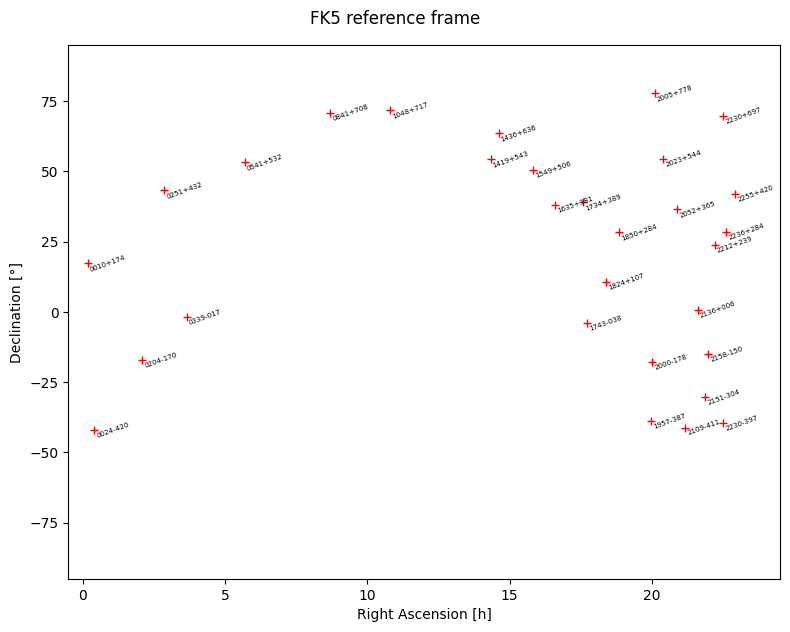

In [12]:
locit_mds.plot_source_positions(locit_plot_folder,   # destination for the plot
                                display_labels=True, # Display source labels on plot
                                precessed=False)     # Plot FK5 coordinates

2023-09-13 11:35:40,980 - WARNING  - astrohack - (_dio.py:329) - [plot_antenna_positions]: Destination folder already exists, results may be overwritten


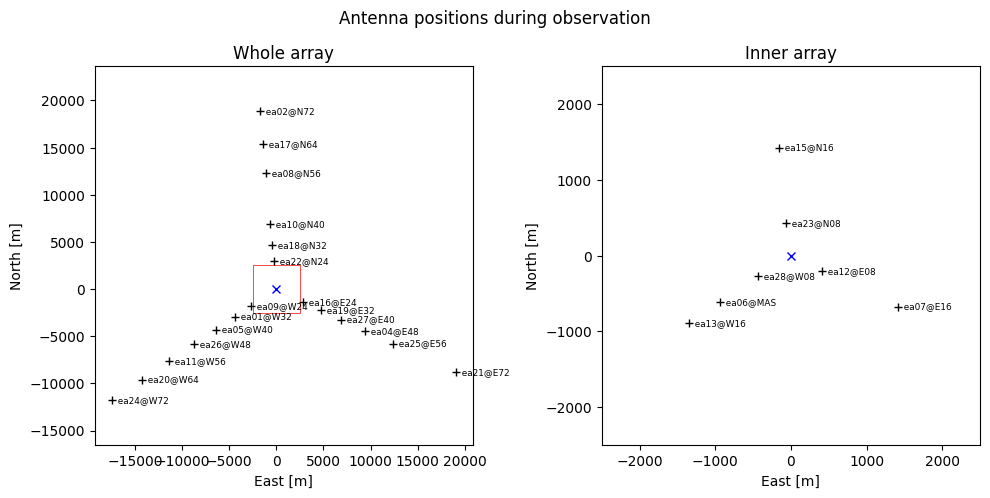

In [13]:
locit_mds.plot_antenna_positions(locit_plot_folder, 
                                 display_stations=True)

Now we proceed to actual fit yada yada yada

In [14]:
%%time
from astrohack.locit import locit
position_mds = locit(locit_name, 
                     position_name=position_name, 
                     elevation_limit=10.0, 
                     polarization='both', 
                     fit_engine='scipy',
                     fit_kterm=False, 
                     fit_slope=True, 
                     ant_id=None, 
                     ddi=None, 
                     combine_ddis=True,
                     parallel=True, 
                     overwrite=True)

2023-09-13 11:35:49,920 - INFO     - astrohack - (_check_parms.py:135) - [locit]: Setting default ant to all.
2023-09-13 11:35:49,921 - INFO     - astrohack - (_check_parms.py:135) - [locit]: Setting default ddi to all.
2023-09-13 11:35:52,465 - INFO     - astrohack - (locit.py:124) - [locit]: Finished processing
CPU times: user 1.27 s, sys: 43.1 ms, total: 1.32 s
Wall time: 2.7 s


In [15]:
position_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                             ./data/locit-input-pha.position.zarr                             ###
####################################################################################################

Attributes:
+-------------------+--------------------------------------+
| Attribute         | Value                                |
+-------------------+--------------------------------------+
| locit_name        | ./data/locit-input-pha.locit.zarr    |
| position_name     | ./data/locit-input-pha.position.zarr |
| elevation_limit   | 10.0                                 |
| fit_engine        | scipy                                |
| polarization      | both                                 |
| fit_kterm         | False                                |
| fit_slope         | True        

In [17]:
position_export_folder = 'position_mds_export'

In [18]:
position_mds.export_fit_results(position_export_folder, 
                                position_unit='m', 
                                delay_unit='nsec',
                                time_unit='hour')


In [20]:
with open(position_export_folder+'/locit_fit_results.txt', 'r') as file:
    for _ in range(30):
        print(file.readline()[:-1])

+------------+------------+-----------------+-----------------+----------------+----------------+------------------+
|  Antenna   | RMS [nsec] | F. delay [nsec] |   X offset [m]  |  Y offset [m]  |  Z offset [m]  | Rate [nsec/hour] |
+------------+------------+-----------------+-----------------+----------------+----------------+------------------+
|    ea01    |  1.57e-02  |   0.015 ± 0.0   |  0.00055 ± 0.0  |  0.0055 ± 0.0  | -0.0016 ± 0.0  |    0.0 ± 0.0     |
|    ea02    |  1.71e-02  |   0.029 ± 0.0   |   0.0034 ± 0.0  |  0.0076 ± 0.0  |  -0.007 ± 0.0  |   -0.002 ± 0.0   |
|    ea03    |    N/A     |       N/A       |       N/A       |      N/A       |      N/A       |       N/A        |
|    ea04    |  2.04e-02  |   -0.035 ± 0.0  |   0.0036 ± 0.0  | -0.0039 ± 0.0  |  0.0033 ± 0.0  |   0.0073 ± 0.0   |
|    ea05    |  1.45e-02  |   0.011 ± 0.0   |   0.0026 ± 0.0  |  0.0034 ± 0.0  | -0.0011 ± 0.0  |  -0.00045 ± 0.0  |
|    ea06    |  5.86e-03  |   0.025 ± 0.0   |  -0.00079 ± 0.0 | 

In [21]:
position_plot_folder = 'position_mds_plots'

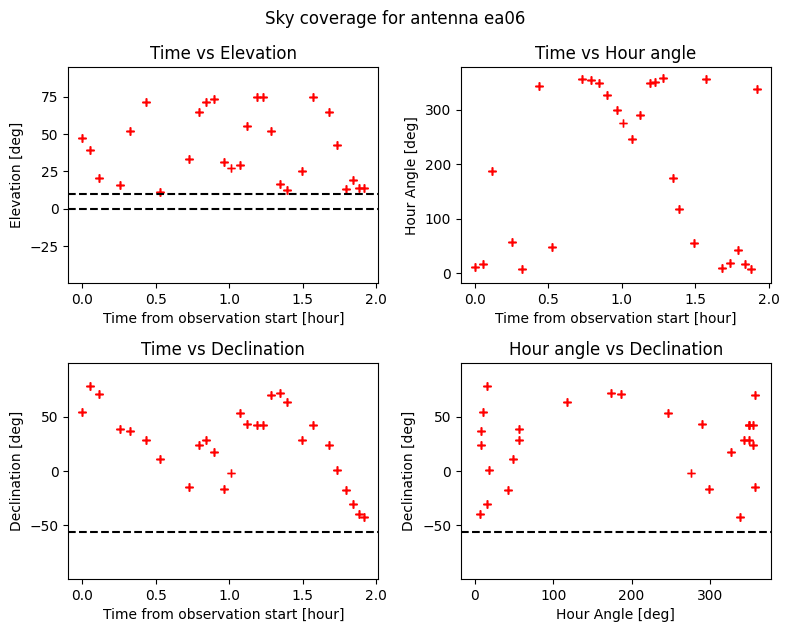

In [22]:
position_mds.plot_sky_coverage(position_plot_folder, 
                               ant_id='ea06',
                               ddi=1,
                               time_unit='hour', 
                               angle_unit='deg', 
                               display=True,
                               figure_size=None,
                               dpi=300,
                               parallel=False)

2023-09-13 11:37:25,408 - INFO     - astrohack - (_check_parms.py:135) - [plot_delays]: Setting default plot_fit to True.
2023-09-13 11:37:25,422 - WARNING  - astrohack - (_dio.py:329) - [plot_delays]: Destination folder already exists, results may be overwritten


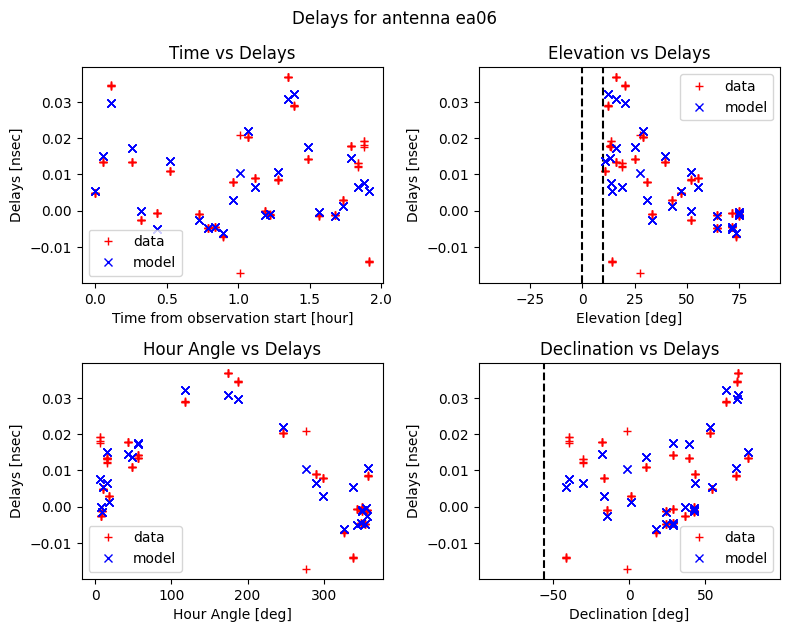

In [24]:
position_mds.plot_delays(position_plot_folder, 
                        ant_id='ea06',
                        ddi=1,
                        time_unit='hour',
                        angle_unit='deg',
                        delay_unit='nsec',
                        plot_model=True,
                        display=True,
                        figure_size=None,
                        dpi=300,
                        parallel=False)